### Discussion
- We used vgg-net embeddings (4096 vectors) and trained a captioning model using LSTM
- LSTMs are used in batch version, where we push a batch x max_seq x embedd_length tensor into lstm
- The batched version supports faster training (les than an hour to do a couple of epochs)
- The BLUE score is 0.69 on validation set
- Since BLEU isn't a good metric, we see a few qualitative results which are quite good.

In [18]:
from collections import Counter, defaultdict
from gensim.models import Word2Vec
from IPython import display
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
import pickle
from random import random
import scipy

%matplotlib inline

In [3]:
# Functions and code in this cell are taken from CS532L assignment4
img_size = 224
loader = transforms.Compose([
  transforms.Scale(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    
    if torch.cuda.is_available():
        image_var = image_var.cuda()
    
    return image_var

load_image('data/train2014/COCO_train2014_000000000009.jpg')

# Load annotations file for the training images.
mscoco_train = json.load(open('data/annotations/train_captions.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}

# Extract out the captions for the training images
train_id_set = set(train_ids)
train_id_to_captions = defaultdict(list)
for entry in mscoco_train['annotations']:
    if entry['image_id'] in train_id_set:
        caption = entry['caption']
        caption = caption.strip(' ')
        caption = caption.strip('.')
        caption = caption + '.'
        train_id_to_captions[entry['image_id']].append(caption)

# Load annotations file for the validation images.
mscoco_val = json.load(open('data/annotations/val_captions.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# Extract out the captions for the validation images
val_id_set = set(val_ids)
val_id_to_captions = defaultdict(list)
for entry in mscoco_val['annotations']:
    if entry['image_id'] in val_id_set:
        val_id_to_captions[entry['image_id']].append(entry['caption'])

# Load annotations file for the testing images
mscoco_test = json.load(open('data/annotations/test_captions.json'))
test_ids = [entry['id'] for entry in mscoco_test['images']]
test_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_test['images']}

sentences = [sentence for caption_set in train_id_to_captions.values() for sentence in caption_set]

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
vocabularySize = 1000
word_counts = Counter([word for sentence in sentences for word in sentence])
vocabulary = ["<UNK>"] + [e[0] for e in word_counts.most_common(vocabularySize-1)]
word2index = {word:index for index,word in enumerate(vocabulary)}
one_hot_embeddings = np.eye(vocabularySize)

# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
w2v = Word2Vec(filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.syn0))

# Define the max sequence length to be the longest sentence in the training data. 
maxSequenceLength = max([len(sentence) for sentence in sentences])

def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentences, predicted_sentence):
    """
    Given a list of reference sentences, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = [word_tokenize(ref_sent.lower()) for ref_sent in reference_sentences]
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu(reference_tokenized, predicted_tokenized)

In [4]:
# Code in this cell taken from: https://gist.github.com/jihunchoi/f1434a77df9db1bb337417854b398df1.
def _sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def compute_loss(logits, target, length):
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.

    Returns:
        loss: An average loss value masked by the length.
    """
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = _sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

### Models

In [5]:
vgg_model = models.vgg16(pretrained=True)
new_classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])
vgg_model.classifier = new_classifier
if torch.cuda.is_available():
    vgg_model = vgg_model.cuda()

class DimentionMapper(nn.Module):
    def __init__(self,image_embedding_dim, lm_hidden_dim):
        super(DimentionMapper, self).__init__()
        self.fc = nn.Linear(image_embedding_dim, lm_hidden_dim)
        
    def forward(self, input):
        return self.fc(input)

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderLSTM,self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax()
        
    def forward(self, input, hidden):
        #output = self.embedding(input).view(1,1,-1)
        output = input
        #output = F.relu(output)     
        output, hidden = self.lstm(output, hidden)
        output = self.fc(output)
        return output, hidden
    
    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))
        if torch.cuda.is_available():
            return (result.cuda(), result.cuda())
        else:
            return (result, result)

hidden_size = 300
lstm_decoder = DecoderLSTM(hidden_size, hidden_size, vocabularySize)
#lstm_model(getInputVec(1), lstm_model.initHidden())
if torch.cuda.is_available():
    lstm_decoder = lstm_decoder.cuda()
lstm_decoder.train()

dimention_mapper = DimentionMapper(4096,hidden_size)
if torch.cuda.is_available():
    dimention_mapper = dimention_mapper.cuda()
dimention_mapper.train()

DimentionMapper (
  (fc): Linear (4096 -> 300)
)

In [6]:
#Load saved vectors
training_vectors = np.load('outputs2/training_vectors')
validation_vectors = np.load('outputs2/validation_vectors')
print(training_vectors.shape)
print(validation_vectors.shape)

with open('outputs2/trainids_to_embeddings.pk', 'rb') as handle:
    trainids_to_embeddings = dict(pickle.load(handle))

with open('outputs2/valids_to_embeddings.pk', 'rb') as handle:
    valids_to_embeddings = dict(pickle.load(handle))

(82783, 4096)
(100, 4096)


### Some helper functions for batching and sequencing in RNNs

In [10]:
def getInputVec_OH(uid, isTarget=False):
    if isinstance(uid,str):
        if uid in word2index:
            word_vec = one_hot_embeddings[word2index[uid]]
        else:
            word_vec = one_hot_embeddings[word2index['<UNK>']]
    elif isinstance(uid,int):
        word_vec = one_hot_embeddings[uid]
    else:
        print('getInputVec: INPUT TYPE IS NOT VALID')
        return -1
            
    if isTarget:
        input_var = Variable(torch.LongTensor(word_vec)).view(1,1,-1)
    else:
        input_var = Variable(torch.FloatTensor(word_vec)).view(1,1,-1)
    if torch.cuda.is_available():
        return input_var.cuda()
    else:
        return input_var

def getInputVec_W2V(uid, isTarget=False):
    if isinstance(uid,str):
        if uid in word2index:
            word_vec = w2v_embeddings[word2index[uid]]
        else:
            word_vec = w2v_embeddings[word2index['<UNK>']]

    elif isinstance(uid,int):
        word_vec = w2v_embeddings[uid]
    else:
        print('getInputVec: INPUT TYPE IS NOT VALID')
        return -1
            
    if isTarget:
        input_var = Variable(torch.LongTensor(word_vec)).view(1,1,-1)
    else:
        input_var = Variable(torch.FloatTensor(word_vec)).view(1,1,-1)
    if torch.cuda.is_available():
        return input_var.cuda()
    else:
        return input_var  

getInputVec = getInputVec_W2V    
    
def create_padded(sentences):
    na_vectors = [preprocess_word2vec(sentence) for sentence in sentences]
    num_vectors = [preprocess_numberize(sentence) for sentence in sentences]
    
    # find the max size of the sequence
    max_size = max([vec.shape[0] for vec in na_vectors])

    #flatten the array
    seq_len = []
    padded_vecs = []
    padded_num_vecs = []
    for idx, vec in enumerate(na_vectors):
        seq_len.append(int(vec.shape[0]))
        deficit = max_size - vec.shape[0]
        def_vec = np.zeros((deficit,vec.shape[1]))
        def_vec.dtype = np.float64
        padded_vec = np.concatenate((vec, def_vec), axis=0)#.reshape(1,max_size,vec.shape[1])
        padded_vecs.append(padded_vec)
        
        padded_num_vec = num_vectors[idx] + list(np.zeros(deficit, dtype=int))
        padded_num_vecs.append(padded_num_vec)
        
        #full_vecs = np.concatenate((full_vecs, full_vec),axis=0)
    return padded_vecs, padded_num_vecs, seq_len

def get_seq_tensor(words_ids):
    data = [[w2v_embeddings[id] for id in words_ids]]
    data = torch.FloatTensor(data)
    return data

def give_chunks(data, size):
    chunks = []
    t_chunk = []
    s=0
    flag=0
    for val in data:
        flag = 0
        if s<size:
            t_chunk.append(val)
            s=s+1
        else:
            flag=1
            chunks.append(t_chunk)
            t_chunk = []
            s=0
            t_chunk.append(val)
            s=s+1
    if flag==0:
        chunks.append(t_chunk)
    return chunks

def get_captions_and_embeddings(chunk):
    captions = []
    embeddings = []
    for train_id in chunk:
        for caption in train_id_to_captions[train_id]:
            captions.append(caption)
            embedding = training_vectors[trainids_to_embeddings[train_id]]
            embeddings.append(embedding)
           
    captions = np.array(captions)
    embeddings = np.array(embeddings)
    return captions, embeddings


### Training
- We use VGG image embeddings and train a language decoder using ms-coco captions
- VGG is not finetuned to save time but its likely to improve results
- Loss goes from 6.4 -> 2.6

In [12]:
# function performs forward and backward step on one batch/seq of inputs on RNN
def train(embeddings_var, input_var, target_var, seq_len_list, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    # input_var -> torch.Size([20, 50, 300]) batch x max_seq x dim
    # targer_var -> torch.Size([50, 20]) batch x max_seq
    # embeddings_var -> torch.Size([50, 4096]) batch x emb_dim
    
    max_seq_len = seq_len_list[0]
    batch_size = input_var.size()[1]
    output_sentences = [[] for i in range(0,batch_size)]
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # mapper step
    #training_vector = Variable(torch.FloatTensor(training_vectors[0:10])).unsqueeze(0)
    hidden_var = encoder(embeddings_var).unsqueeze(0) # dim -> 1 x batch x dim
    hidden_var = (hidden_var, hidden_var)

    # push <SOS> inside the decoder
    de_input_var = [[w2v_embeddings[word2index['<SOS>']] for i in range(0,batch_size)]]
    de_input_var = Variable(torch.FloatTensor(de_input_var))
    if torch.cuda.is_available():
        de_input_var = de_input_var.cuda()
    

    # the first target should be corresponsing to <SOS> only
    all_decoder_outputs = Variable(torch.zeros(max_seq_len, batch_size, len(vocabulary)))
    if torch.cuda.is_available():
        all_decoder_outputs = all_decoder_outputs.cuda()
    sos_target = [one_hot_embeddings[word2index['<SOS>']] for ii in range(0, batch_size)]
    sos_target =  Variable(torch.FloatTensor(sos_target))
    if torch.cuda.is_available():
        sos_target = sos_target.cuda()
    all_decoder_outputs[0] = sos_target
    
    for t in range(1, max_seq_len):
        decoder_output, hidden_var = decoder(de_input_var, hidden_var)
        topv, topi = softmaxnew(decoder_output[0]).data.topk(1)
        word_ids = [idd[0] for idd in topi]
        
        # Teacher forcing
        if random() <= teacher_forcing_ratio:
            de_input_var = input_var[t].unsqueeze(0)
        else:
            de_input_var = Variable(get_seq_tensor(word_ids))

#         de_input_var = Variable(get_seq_tensor(word_ids))    
        if torch.cuda.is_available():
            de_input_var = de_input_var.cuda()
        all_decoder_outputs[t] = decoder_output[0]
        
        # add to output sentences
        for iddd, word_id in enumerate(word_ids):
            output_sentences[iddd].append(vocabulary[word_id])
        
    seq_list_var = Variable(torch.LongTensor(seq_len_list))
    if torch.cuda.is_available():
        seq_list_var = seq_list_var.cuda()
    
    loss = compute_loss(all_decoder_outputs.transpose(0,1).contiguous(),
                         target_var.contiguous(),
                        seq_list_var)
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0], output_sentences

teacher_forcing_ratio = 1
learning_rate = 0.0001
batch_size_images = 20
epochs = 1

softmaxnew = torch.nn.Softmax()
chunks = give_chunks(list(train_ids),batch_size_images)

encoder_optimizer = optim.Adam(dimention_mapper.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(lstm_decoder.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

for _ in range(0,epochs):
    losses = []
    for cid,chunk in enumerate(chunks):
        result = get_captions_and_embeddings(chunk)
        chunk_captions = result[0]
        chunk_images = result[1]
        
        sorter = list(np.flip(np.argsort([len(word_tokenize(stri.lower())) for stri in chunk_captions]),0))
        chunk_captions_sorted = chunk_captions[sorter]
        chunk_images_sorted = chunk_images[sorter]
        batch_size = len(chunk_captions_sorted) # this is diff as we are appending all captions

        p_input, target, seq_len_list = create_padded(chunk_captions_sorted)

        p_input = Variable(torch.FloatTensor(p_input))
        if torch.cuda.is_available():
            p_input = p_input.cuda()

        input_var = p_input.transpose(0,1)

        # create target variable
        target_var = Variable(torch.LongTensor(np.array(target)))
        if torch.cuda.is_available():
            target_var = target_var.cuda()    
            
        #create embeddings var
        embeddings_var = Variable(torch.FloatTensor(chunk_images_sorted))
        if torch.cuda.is_available():
            embeddings_var = embeddings_var.cuda()    

        # Compute loss and take step on network
        out_data = train(embeddings_var, input_var, target_var, seq_len_list, dimention_mapper, lstm_decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = out_data[0]
        output_sentences = out_data[1]
        losses.append(loss)

        if cid%100 ==0:
            print("\n" + str(cid) + " Mean - " + str(np.mean(losses)) + ' | Value - ' + str(losses[-1]))
            print(chunk_captions_sorted[0])
            print(' '.join(output_sentences[0]))


0 Mean - 3.00206875801 | Value - 3.0020687580108643
The view shows two young people and  a woman leaving an elaborate entry way that includes a curved wall and window, revealing chefs at work,.
a <UNK> of of <UNK> <UNK> are a <UNK> <UNK> . <UNK> . . . is <UNK> <UNK> <UNK> . a . <UNK> <UNK> . the . <UNK> <EOS>

100 Mean - 2.81499231688 | Value - 2.764280080795288
A laptop a figurine doll with no dress and red hair and a pair of scissors on a table.
a woman is <UNK> <UNK> on a <UNK> <UNK> a <UNK> . a <UNK> of <UNK> . a table . <EOS>

200 Mean - 2.81164865707 | Value - 2.9014596939086914
Reminds me of my trip to Venice. Going under the bridge in a boat is so romantic.
a <UNK> <UNK> a <UNK> <UNK> <UNK> a <EOS> down a <UNK> . the <UNK> . . . . <EOS>

300 Mean - 2.8075390068 | Value - 2.743022918701172
A picture taken behind first plate of a pitch being thrown to a batter at a near sold out baseball game.
a group of <UNK> a <UNK> with a <UNK> <UNK> <UNK> . <UNK> <UNK> . a <UNK> a . of . . <


3200 Mean - 2.69586379898 | Value - 2.6874570846557617
A zebra, close up from the side, walking across a road to grass area.
a zebra standing <UNK> up of a <UNK> of a in the <UNK> . <UNK> . . <EOS>

3300 Mean - 2.69346512177 | Value - 2.603736639022827
A close of up of the chest of a man wearing a bow tie with the caption "Bow Tie Tuesday".
a man up a of a <UNK> of a <UNK> . a <UNK> <UNK> . a <UNK> . <UNK> <UNK> . . . <EOS>

3400 Mean - 2.69081510154 | Value - 2.624136447906494
In the water by grass and wall, two bears with mouths open and noses touching and another one bear a few feet away.
a a <UNK> <UNK> a with a . and <UNK> . <UNK> <UNK> . <UNK> . . <UNK> <UNK> . . <UNK> <UNK> . <UNK> <EOS>

3500 Mean - 2.68739181415 | Value - 2.7028870582580566
A woman's handbag with the contents poured out of it, including a hair brush , gum and other items.
a <UNK> is <UNK> <UNK> a <UNK> <UNK> . of a . <UNK> a <UNK> . . and and <UNK> <UNK> . <EOS>

3600 Mean - 2.68495995182 | Value - 2.70463967

### Results

In [13]:
def inference(encoder, decoder, image_embedding, getInputVec=getInputVec, max_length=maxSequenceLength):
    embeddings_var = Variable(torch.FloatTensor(image_embedding)).unsqueeze(0)
    if torch.cuda.is_available():
        embeddings_var = embeddings_var.cuda()    

    # the embedding mapping part
    #en_hidden_var
    hidden_var = encoder(embeddings_var).unsqueeze(0) # dim -> 1 x batch x dim
    hidden_var = (hidden_var, hidden_var)
    
    # decoder part
    output_sentence = []
    input_var = getInputVec('<SOS>')
    pred_word = '<SOS>'
    while pred_word != '<EOS>':
        output_var, hidden_var = decoder(input_var, hidden_var)

        # update the next input variable
        topv, topi = softmaxnew(output_var[0]).data.topk(1)
        #print(output_var.shape)
        ni = int(topi[0][0]) # returns 0-999 (index)
        input_var = getInputVec(ni)
        
        pred_word = vocabulary[ni]
        #print(pred_word)
        output_sentence.append(pred_word)
    return output_sentence

all_bleu = []
for image_id in val_ids:
    image_embedding = vgg_model(load_image(val_id_to_file[image_id])).squeeze(0)
    image_embedding = image_embedding.cpu().data.numpy()
    output_sentence = inference(dimention_mapper, lstm_decoder, image_embedding)
    out_sentence = ' '.join(output_sentence)
    out_sentence = '<SOS> ' +  out_sentence    
    
    orig_captions = val_id_to_captions[image_id]

    orig_sentences = []
    for orig_caption in orig_captions:
        orig_caption = orig_caption.strip('.')
        orig_caption = orig_caption + ' .'
        orig_caption = '<SOS> ' +  orig_caption + ' <EOS>'
        bleu_score = compute_bleu(orig_caption, out_sentence)
        all_bleu.append(bleu_score)
        orig_sentences.append(orig_caption + ' | ' + str(bleu_score))
    print('\n'.join(orig_sentences))
    print(out_sentence)
    print(bleu_score)
    print('\n')
    
print('Mean - ' + str(np.mean(all_bleu)))    

/anaconda/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


<SOS> A zebra in captivity grazing in its exhibit . <EOS> | 0.7186082239261684
<SOS> The zebra is eating grass in his habitat . <EOS> | 0.7186082239261684
<SOS> A zebra grazing in an enclosure with trees in the background . <EOS> | 0.7186082239261684
<SOS> A zebra brazing on green grass next to a pile of rocks . <EOS> | 0.7186082239261684
<SOS> A zebra eating grass inside a fenced in area.  . <EOS> | 0.7186082239261684
<SOS> a zebra standing in a field of grass . <EOS>
0.7186082239261684


<SOS> a person and a dog are standing near some cliffs . <EOS> | 0.7071067811865476
<SOS> A person walks with a backpack being followed by a dog . <EOS> | 0.7071067811865476
<SOS> A hiker and dogs are walking in a canyon . <EOS> | 0.7071067811865476
<SOS> A person walks along on a patch of sand near some rocks . <EOS> | 0.7071067811865476
<SOS> A person walking across a desert filled surrounded by mountains . <EOS> | 0.7071067811865476
<SOS> a man is riding a surfboard on a beach . <EOS>
0.7071067811

<SOS> A zebra standing on top of a grass covered field . <EOS> | 0.6865890479690392
<SOS> there is a very beautiful zebra that is standing in the shade . <EOS> | 0.6865890479690392
<SOS> A zebra showing the left side of itself on a field . <EOS> | 0.6865890479690392
<SOS> A zebra is standing in an open field . <EOS> | 0.6865890479690392
<SOS> a large zebra standing next to a tree . <EOS> | 0.6865890479690392
<SOS> a zebra standing in a field with a <UNK> . <EOS>
0.6865890479690392


<SOS> Two zebras fighting in a cloud of dust . <EOS> | 0.7186082239261684
<SOS> Two zebras fighting in a open area with green bushes . <EOS> | 0.7186082239261684
<SOS> Two zebras are battling each other on hind legs . <EOS> | 0.7186082239261684
<SOS> Two zebra having a fight on top of a dry grass field . <EOS> | 0.7186082239261684
<SOS> Two zebras in a jungle area fighting in a dirt area . <EOS> | 0.7186082239261684
<SOS> a group of zebras standing in a field . <EOS>
0.7186082239261684


<SOS> Two zebras pl

<SOS> Horses stand and drink from pond water near the road . <EOS> | 0.7186082239261684
<SOS> horses near a body of water with a sky background . <EOS> | 0.7186082239261684
<SOS> Horses behind a fence near a body of water . <EOS> | 0.7186082239261684
<SOS> Horses grazing in a muddy portion of a flooded field . <EOS> | 0.7186082239261684
<SOS> Five horses next to a body of water behind a fence . <EOS> | 0.7186082239261684
<SOS> a group of people standing on a field . <EOS>
0.7186082239261684


<SOS> A horse is attached to a carriage.  . <EOS> | 0.668740304976422
<SOS> A horse drawn carriage moving down the street, people walking to the side of it . <EOS> | 0.668740304976422
<SOS> People standing around near a horse drawn buggy . <EOS> | 0.668740304976422
<SOS> A horse pulling a carriage next to a crowd of people . <EOS> | 0.668740304976422
<SOS> A close-up of the horse that's pulling a carriage . <EOS> | 0.668740304976422
<SOS> a man riding a horse on a <UNK> <UNK> . <EOS>
0.66874030497

<SOS> A man riding on the back of a brown horse . <EOS> | 0.7071067811865476
<SOS> A horse racing track at the Saratoga Race Course, with a horse and jockey running on the track, as another horse and jockey wait on the side . <EOS> | 0.7071067811865476
<SOS> a couple of horses on the race track with only one running on it  . <EOS> | 0.7071067811865476
<SOS> A person on a horse on a dirt field . <EOS> | 0.7071067811865476
<SOS> A jockey and his horse waiting on the side line . <EOS> | 0.7071067811865476
<SOS> a man is riding a horse on a beach . <EOS>
0.7071067811865476


<SOS> Two men riding horses at a horse racing track . <EOS> | 0.6964705665515708
<SOS> Two race horses running on a dirt track . <EOS> | 0.6964705665515708
<SOS> One horse trails behind another during a race . <EOS> | 0.6964705665515708
<SOS> Two horses are racing on a track.  . <EOS> | 0.6964705665515708
<SOS> Two horses and their riders on the race track . <EOS> | 0.6964705665515708
<SOS> a man is sitting on a bench 

<SOS> A group of children playing baseball out side . <EOS> | 0.6865890479690392
<SOS> Group of children with baseball gloves throwing balls back and forth . <EOS> | 0.6865890479690392
<SOS> Some children are playing softball on a field . <EOS> | 0.6865890479690392
<SOS> this is a group of children playing baseball . <EOS> | 0.6865890479690392
<SOS> A group of kids that are standing in the grass . <EOS> | 0.6865890479690392
<SOS> a group of people standing in a field with a frisbee . <EOS>
0.6865890479690392


<SOS> Many calendars and bunches of bananas hanging on a wall . <EOS> | 0.645777692487244
<SOS> Clusters of bananas and pictures hanging on a wall . <EOS> | 0.645777692487244
<SOS> A large group of bananas hanging in front of posters . <EOS> | 0.645777692487244
<SOS> Bunches of bananas hung on display at a  market . <EOS> | 0.645777692487244
<SOS> Bunches of bananas stacked on top of magazines.  . <EOS> | 0.645777692487244
<SOS> a <UNK> of <UNK> <UNK> on a <UNK> . <EOS>
0.6457776

<SOS> A man is on the ski slope on a sunny day . <EOS> | 0.7311104457090247
<SOS> a man skiing on the side of a hill . <EOS> | 0.7311104457090247
<SOS> A single skier stands still on the slopes and casts a shadow in the snow . <EOS> | 0.7311104457090247
<SOS> Man skiing down snow covered mountain side in the ice weather . <EOS> | 0.7311104457090247
<SOS> A person who is all bundled up standing in the snow on skis . <EOS> | 0.7311104457090247
<SOS> a person on skis in the snow . <EOS>
0.7311104457090247


<SOS> A person wearing a banana headdress and necklace . <EOS> | 0.6147881529512643
<SOS> A lady dressed in a blue and purple outfit wearing a hat made of fruit . <EOS> | 0.6147881529512643
<SOS> A person wearing a hat made out of yellow bananas . <EOS> | 0.6147881529512643
<SOS> Person with bananas on head and banana necklace . <EOS> | 0.6147881529512643
<SOS> A woman wears a hat that is made of bananas . <EOS> | 0.6147881529512643
<SOS> a woman <UNK> a <UNK> <UNK> <UNK> <UNK> <UNK> .

### Looking at some images

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<SOS> a zebra standing in a field with a <UNK> . <EOS>


<SOS> a zebra standing in a field of grass . <EOS>




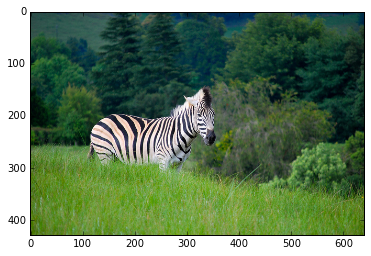

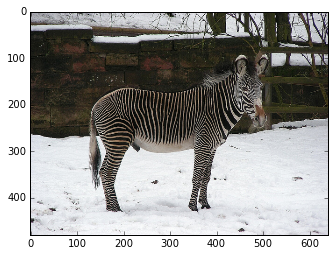

In [19]:
for image_id in val_ids[5:7]:
    image_embedding = vgg_model(load_image(val_id_to_file[image_id])).squeeze(0)
    image_embedding = image_embedding.cpu().data.numpy()
    output_sentence = inference(dimention_mapper, lstm_decoder, image_embedding)
    out_sentence = ' '.join(output_sentence)
    out_sentence = '<SOS> ' +  out_sentence    
    
    orig_captions = val_id_to_captions[image_id]

    orig_sentences = []
    for orig_caption in orig_captions:
        orig_caption = orig_caption.strip('.')
        orig_caption = orig_caption + ' .'
        orig_caption = '<SOS> ' +  orig_caption + ' <EOS>'
        orig_sentences.append(orig_caption + ' | ' + str(bleu_score))

    image = scipy.misc.imread(val_id_to_file[image_id])
    matplotlib.pyplot.figure()
    matplotlib.pyplot.imshow(image)
    #print('\n'.join(orig_sentences))
    
    print(out_sentence)
    print('\n')


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


<SOS> a bear standing in a <UNK> <UNK> in a field . <EOS>




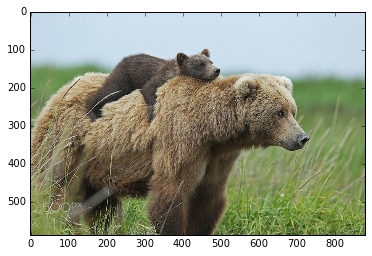

In [21]:
# try some random stuff
file_name = 'pics/d.jpg'
image_embedding = vgg_model(load_image(file_name)).squeeze(0)
image_embedding = image_embedding.cpu().data.numpy()
output_sentence = inference(dimention_mapper, lstm_decoder, image_embedding)
out_sentence = ' '.join(output_sentence)
out_sentence = '<SOS> ' +  out_sentence    

image = scipy.misc.imread(file_name)
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(image)
#print('\n'.join(orig_sentences))

print(out_sentence)
print('\n')
